# Using datasketch to find related sets in large corpora

Computing the exact value for Jaccard similarity or containment for all pairs of sets in the corpus can be an expensive task. Let us consider for instance a corpus composed of 10k tables. Selected a query table and a column out of it, represented as a set of cells, we want to retrieve all tables in the corpus that are joinable with the query table on that column.

In [ ]:
import lzma
import pandas as pd
import pickle as pkl

In [ ]:
tables = pkl.load(lzma.LZMAFile("datasets/joinable_tables/joinable_tables.pkl", "rb"))
id_mapping = {tables[i]["_id"]: i for i in range(0, len(tables))}  # map table ids to their indices inside the table list
len(tables)

In [ ]:
print(tables[0]["_id"])
print(tables[0]["context"])
pd.DataFrame(tables[0]["content"], columns=tables[0]["headers"])

In [ ]:
gt = pd.read_csv("datasets/joinable_tables/joinable_tables.csv")
gt

datasketch provides probabilistic data structures that can process and search very large amount of data super fast, with little loss of accuracy.

https://ekzhu.com/datasketch/

In [ ]:
import datasketch

## MinHash

datasketch.MinHash can be used to estimate the Jaccard similarity (resemblance) between sets of arbitrary sizes in linear time using a small and fixed memory space.

https://ekzhu.com/datasketch/minhash.html

In [ ]:
from datasketch import MinHash

Let us consider two sets of values (e.g., two tokenized sentences).

In [ ]:
data1 = ['minhash', 'is', 'a', 'probabilistic', 'data', 'structure', 'for', 'estimating', 'the', 'similarity', 'between', 'datasets']
data2 = ['minhash', 'is', 'a', 'probability', 'data', 'structure', 'for', 'estimating', 'the', 'similarity', 'between', 'documents']

We can estimate their Jaccard similarity through MinHash.

In [ ]:
m1 = MinHash()  # by default 128 permutations, but the number can be adjusted, e.g., by setting num_perm=256
for d in data1:
    m1.update(d.encode('utf8'))
m1.hashvalues

In [ ]:
m2 = MinHash()
for d in data2:
    m2.update(d.encode('utf8'))
m2.hashvalues

In [ ]:
m1.jaccard(m2)

\[For students\] Let us check the exact value for the Jaccard similarity computed between the two sets of values.

In [ ]:
s1 = set(data1)
s2 = set(data2)
# actual_jaccard = # write your solution here
actual_jaccard

But always keep in mind the shortcomings of Jaccard similarity...

In [ ]:
data1 = ['minhash', 'is', 'a', 'probabilistic', 'data', 'structure', 'for', 'estimating', 'the', 'similarity', 'between', 'datasets']
data2 = ['similarity', 'between', 'datasets']

m1, m2 = MinHash(), MinHash()
for d in data1:
    m1.update(d.encode('utf8'))
for d in data2:
    m2.update(d.encode('utf8'))
m1.jaccard(m2)

## MinHash LSH

\[For students\] Suppose you have a very large collection of sets. Given a query, which is also a set, you want to find sets in your collection that have Jaccard similarities above certain threshold, and you want to do it with many other queries. To do this efficiently, you can create a MinHash for every set, and when a query comes, you compute the Jaccard similarities between the query MinHash and all the MinHash of your collection, and return the sets that satisfy your threshold. 

In particular, let us consider:
- table "35424124-1_0" as the query table
- and its first column as the query column
- different thresholds too, e.g., 0.7 and 0.5

In [ ]:
q_table_id = "35424124-1_0"
q_table_index = id_mapping[q_table_id]
print(tables[q_table_index]["context"])
pd.DataFrame(tables[q_table_index]["content"], columns=tables[q_table_index]["headers"]).head()

In [ ]:
%%time
minhash_list = list()
# write your solution here
# we want to insert in minhash_list tuples representing columns:
# in the form: (tables[table_id]["_id"] + "_" + str(col_id), m), where m is the minhash of th column

In [ ]:
q_col_id = 0
q_col_set = {row[q_col_id] for row in tables[q_table_index]["content"]}
qm = MinHash()
for val in list(q_col_set):
    qm.update(val.encode('utf8'))
join_cols = list()
for col in minhash_list:
    if qm.jaccard(col[1]) >= 0.5:
        join_cols.append(col[0])
join_cols

The said approach is still an O(n) algorithm, meaning the query cost increases linearly with respect to the number of sets. A popular alternative is to use Locality Sensitive Hashing (LSH) index. LSH can be used with MinHash to achieve sub-linear query cost - that is a huge improvement.

In [ ]:
from datasketch import MinHashLSH

In [ ]:
set1 = set(['minhash', 'is', 'a', 'probabilistic', 'data', 'structure', 'for', 'estimating', 'the', 'similarity', 'between', 'datasets'])
set2 = set(['minhash', 'is', 'a', 'probability', 'data', 'structure', 'for', 'estimating', 'the', 'similarity', 'between', 'documents'])
set3 = set(['similarity', 'between', 'documents'])

In [ ]:
m1 = MinHash(num_perm=128)
m2 = MinHash(num_perm=128)
m3 = MinHash(num_perm=128)
for d in set1:
    m1.update(d.encode('utf8'))
for d in set2:
    m2.update(d.encode('utf8'))
for d in set3:
    m3.update(d.encode('utf8'))

In [ ]:
lsh = MinHashLSH(threshold=0.5, num_perm=128)
lsh.insert("m2", m2)
lsh.insert("m3", m3)
lsh.query(m1)

Define the query table and column and compute its MinHash.

In [ ]:
q_table_id = "35424124-1_0"
q_table_index = id_mapping[q_table_id]
q_col_id = 0
q_col_set = {row[q_col_id] for row in tables[q_table_index]["content"]}
qm = MinHash(num_perm=128)
for val in list(q_col_set):
    qm.update(val.encode('utf8'))

Let us reply the previous search for joinable columns using MinHash LSH. First, insert into the LSH index the MinHash of all table columns in the corpus.

In [ ]:
lsh = MinHashLSH(threshold=0.5, num_perm=128)
for table_index in range(0, len(tables)):  # for each table
    if tables[table_index]["_id"] != q_table_id:
        for col_id in range(0, len(tables[table_index]["headers"])):  # for each column of the table
            col_set = {row[col_id] for row in tables[table_index]["content"]}
            m = MinHash(num_perm=128)
            for val in list(col_set):
                m.update(val.encode('utf8'))
            lsh.insert(tables[table_index]["_id"] + "_" + str(col_id), m)

Then, obtain the ones with a Jaccard similarity above the defined threshold.

In [ ]:
%%time
## compare the time with the previous approach
lsh.query(qm)

In [ ]:
print(lsh.b, lsh.r)

\[For students\] datasketch supports table querying scenario. Nevertheless, finding all pairs of sets whose similarity overcomes the defined threshold is useful in many cases. Therefore, try to implement MinHash LSH Banding to obtain all pairs of similar sets in the corpus.

In [ ]:
# Compute MinHash for each table column
minhash_list = list()
for table_id in range(0, len(tables)):  # for each table
    for col_id in range(0, len(tables[table_id]["headers"])):  # for each column of the table
        col_set = {row[col_id] for row in tables[table_id]["content"]}
        m = MinHash()
        for val in list(col_set):
            m.update(val.encode('utf8'))
        minhash_list.append((tables[table_id]["_id"] + "_" + str(col_id), m))

In [ ]:
# Perform MinHash LSH Banding
minhash_size = 128
num_bands = 16
num_rows = int(minhash_size / num_bands)  # number of rows in each band
# write your solution here (check the slides)

In [ ]:
from itertools import combinations

In [ ]:
# Generate the pairs of similar sets
set_pairs = set()  # set to store the distinct set pairs
for cluster in clusters:  # for each cluster
    cluster_set_pairs = list(combinations(sorted(cluster["sets"]), 2))  # compute the set pairs
    for set_pair in cluster_set_pairs:  # add each table pair to the set pairs
        set_pairs.add(set_pair)
len(set_pairs)

In [ ]:
list(set_pairs)[:10]

# MinHash LSH Forest

MinHash LSH is useful for threshold queries. However, top-k queries are often more useful in some cases. LSH Forest is a general LSH data structure that makes top-k query possible for many different types of LSH indexes, including MinHash LSH. MinHash LSH Forest returns therefore the top-k matching sets that have the approximately highest Jaccard similarity with the query set.

In [ ]:
q_table_id = "23912408-1_0"
q_table_index = id_mapping[q_table_id]
print(tables[q_table_index]["_id"])
print(tables[q_table_index]["context"])
pd.DataFrame(tables[q_table_index]["content"], columns=tables[q_table_index]["headers"])

In [ ]:
gt[gt["query_table"] == q_table_id]

In [ ]:
table_index = id_mapping["23912408-1_3"]
pd.DataFrame(tables[table_index]["content"], columns=tables[table_index]["headers"]).head()

In [ ]:
q_col_id = 0
q_col_set = {row[q_col_id] for row in tables[q_table_index]["content"]}
qm = MinHash(num_perm=128)
for val in list(q_col_set):
    qm.update(val.encode('utf8'))
q_col_set

In [ ]:
lsh = MinHashLSH(threshold=0.5, num_perm=128)
for table_index in range(0, len(tables)):  # for each table
    if tables[table_index]["_id"] != q_table_id:
        for col_id in range(0, len(tables[table_index]["headers"])):  # for each column of the table
            col_set = {row[col_id] for row in tables[table_index]["content"]}
            m = MinHash(num_perm=128)
            for val in list(col_set):
                m.update(val.encode('utf8'))
            lsh.insert(tables[table_index]["_id"] + "_" + str(col_id), m)

In [ ]:
lsh.query(qm)

In [ ]:
table_index = id_mapping["23912408-1_2"]
pd.DataFrame(tables[table_index]["content"], columns=tables[table_index]["headers"]).head()

In [ ]:
from datasketch import MinHashLSHForest

In [ ]:
forest = MinHashLSHForest(num_perm=128)
for table_index in range(0, len(tables)):  # for each table
    if tables[table_index]["_id"] != q_table_id:
        for col_id in range(0, len(tables[table_index]["headers"])):  # for each column of the table
            col_set = {row[col_id] for row in tables[table_index]["content"]}
            m = MinHash(num_perm=128)
            for val in list(col_set):
                m.update(val.encode('utf8'))
            forest.add(tables[table_index]["_id"] + "_" + str(col_id), m)
forest.index()

In [ ]:
forest.query(qm, 5)

## MinHash LSH Ensemble

LSH Ensemble is a LSH index for containment search: given a query set, it returns sets with containment above a certain threshold.

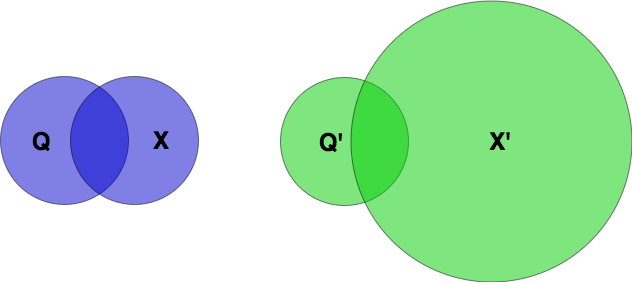

https://ekzhu.com/datasketch/lshensemble.html

In [ ]:
from datasketch import MinHashLSHEnsemble

In [ ]:
q_table_id = "23912408-1_0"
q_table_index = id_mapping[q_table_id]
q_col_id = 0
q_col_set = {row[q_col_id] for row in tables[q_table_index]["content"]}
qm = MinHash(num_perm=128)
for val in list(q_col_set):
    qm.update(val.encode('utf8'))

In [ ]:
lshensemble = MinHashLSHEnsemble(threshold=0.8, num_perm=128, num_part=32)
triples = list()  # an iterable of (key, minhash, size)
for table_index in range(0, len(tables)):  # for each table
    if tables[table_index]["_id"] != q_table_id:
        for col_id in range(0, len(tables[table_index]["headers"])):  # for each column of the table
            col_set = {row[col_id] for row in tables[table_index]["content"]}
            m = MinHash(num_perm=128)
            for val in list(col_set):
                m.update(val.encode('utf8'))
            triples.append((tables[table_index]["_id"] + "_" + str(col_id), m, len(col_set)))
lshensemble.index(triples)

In [ ]:
[key for key in lshensemble.query(qm, len(q_col_set))]

## Bonus: Tokenization

In [ ]:
gt[gt["query_table"] == q_table_id]

In [ ]:
table_index = id_mapping["23912408-1_6"]
pd.DataFrame(tables[table_index]["content"], columns=tables[table_index]["headers"]).head()

\[For students\] Note that we can tokenize our cell values at different levels.

In [ ]:
import re

In [ ]:
q_col_id = 0
q_col_set = {token for row in tables[q_table_index]["content"] for token in re.split(" |-|_|'", row[q_col_id])}
qm = MinHash(num_perm=128)
for val in list(q_col_set):
    qm.update(val.encode('utf8'))
q_col_set

In [ ]:
lshensemble = MinHashLSHEnsemble(threshold=0.8, num_perm=128, num_part=32)
triples = list()  # an iterable of (key, minhash, size)
# write your solution here
lshensemble.index(triples)

In [ ]:
[key for key in lshensemble.query(qm, len(q_col_set))]